# Analyzing CIA Factbook Data

In this project, we'll work with data from the [CIA Worl Factbook](https://www.cia.gov/library/publications/the-world-factbook/), a compendium of statistics of all the countries on Earth. The factbook contains demographic information like:
- <code style="color:red">population</code> - The population as of <code style="color:red">2015</code>
- <code style="color:red">population_growth</code> - The annual population growth rate, as a percentage.
- <code style="color:red">area</code> - The total land and water area.

You can download the SQLite database, <code style="color:red">factbook.db</code>, from [this GitHub repo](https://github.com/factbook/factbook.sql/releases).

First let's get familiar with the database. Let's check the tables in our database and see the first 5 rows of data of the <code style="color:red">facts</code> table.

In [2]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('factbook.db')
query = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(query, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [3]:
query = "select * from facts limit 5"
pd.read_sql_query(query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the descriptions for some of the columns:
- <code style="color:red">name</code> - The name of the country.
- <code style="color:red">population</code> - The country's population.
- <code style="color:red">population_growth</code>- The country's population growth as a percentage.
- <code style="color:red">birth_rate</code> - The country's birth rate, or the number of births a year per 1,000 people.
- <code style="color:red">death_rate</code> - The country's death rate, or the number of death a year per 1,000 people.
- <code style="color:red">area</code> - The country's total area (both land and water).
- <code style="color:red">area_land</code> - The country's land area in square kilometers.
- <code style="color:red">area_water</code> - The country's waterarea in square kilometers.


# Summary Statistics

In [20]:
query = """
select min(population) as min_population,
       max(population) as max_population,
       min(population_growth) as min_population_growth,
       max(population_growth) as max_population_growth
  from facts"""
pd.read_sql_query(query, conn)

,min_population,max_population,min_population_growth,max_population_growth
0,0,7256490011,0.0,4.02


A few things stick out from the summary statistics we just calculated:
- there's a country with a population of <code style="color:red">0</code>
- there's a country with a population of <code style="color:red">7256490011</code> (or more than 7.2 billion people)

Let's zoom is on just these countries.

In [15]:
# countries with population 0
query = 'select * from facts where population = 0'
pd.read_sql_query(query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AB4D1F4908>,
      dtype=object)

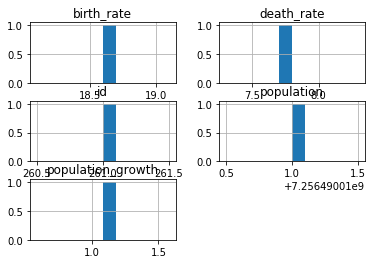

In [24]:
# countries with population 7256490011
query = 'select * from facts where population = 7256490011'
pd.read_sql_query(query, conn)

We can see from the previous queries that the country with population with 0 population is <code>Antarctica</code>, and the country with population 7.2 billion is <code>World></code>, which seems to be a row for the whole worls, and explains such a big number.

# Histograms

Let's move on to generate histograms for the rest of the countries in the table, ignoring these 2 rows. We will write a query that returns all the values in the columns we want to visualize

I:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AB504DD7B8>,
      dtype=object)

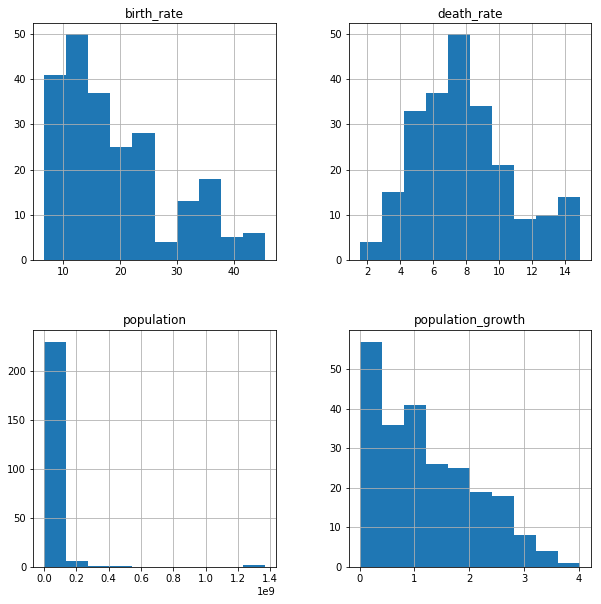

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

query = '''
select population, population_growth, birth_rate, death_rate
  from facts
 where population not in (0, 7256490011)
'''
pd.read_sql_query(query, conn).hist(ax=ax)

# Which countries have the highest population density?

In [49]:
query = '''
select name, 
       area, 
       population, 
       round(cast(population as float)/cast(area as float), 2) as pop_density
  from facts
 order by pop_density desc
 limit 10
'''

pd.read_sql_query(query, conn)

,name,area,population,pop_density
0,Macau,28,592731,21168.96
1,Monaco,2,30535,15267.50
2,Singapore,697,5674472,8141.28
3,Hong Kong,1108,7141106,6445.04
4,Gaza Strip,360,1869055,5191.82
5,Gibraltar,6,29258,4876.33
6,Bahrain,760,1346613,1771.86
7,Maldives,298,393253,1319.64
8,Malta,316,413965,1310.02
9,Bermuda,54,70196,1299.93


# Histogram of population densities

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AB521C6438>],
      dtype=object)

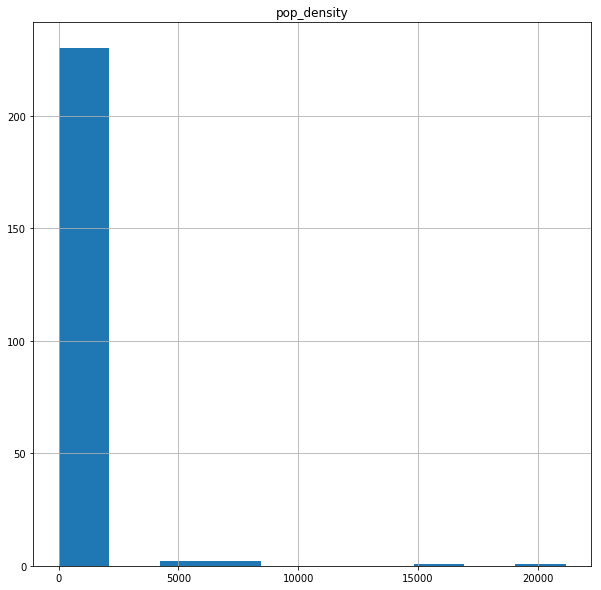

In [52]:
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

query = '''
select round(cast(population as float)/cast(area as float), 2) as pop_density
  from facts
 where population not in (0, 7256490011)
'''
pd.read_sql_query(query, conn).hist(ax=ax)

# Countries with the highest ratios of water to land

In [60]:
query = '''
select name, 
       area, 
       area_land, 
       area_water,
       cast(area_water as float) / cast(area_land as float) as 'water_to_land_ratio'
  from facts
 where population not in (0, 7256490011)
 order by water_to_land_ratio desc
 limit 10
'''
pd.read_sql_query(query, conn)

,name,area,area_land,area_water,water_to_land_ratio
0,Virgin Islands,1910,346,1564,4.520231
1,Puerto Rico,13791,8870,4921,0.554791
2,"Bahamas, The",13880,10010,3870,0.386613
3,Guinea-Bissau,36125,28120,8005,0.284673
4,Malawi,118484,94080,24404,0.259396
5,Netherlands,41543,33893,7650,0.225710
6,Uganda,241038,197100,43938,0.222922
7,Eritrea,117600,101000,16600,0.164356
8,Liberia,111369,96320,15049,0.156240
9,Bangladesh,148460,130170,18290,0.140509
